# Problem statement

In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.

For many incumbent operators, retaining high profitable customers is the number one business
goal. To reduce customer churn, telecom companies need to predict which customers are at high risk of churn. In this project, you will analyze customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn, and identify the main indicators of churn.

In [203]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import re

pd.set_option("display.max_columns",300)
pd.set_option("display.max_rows",300)


from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
import statsmodels.api as sm
# import required libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_roc_curve

In [204]:
#read data
churn = pd.read_csv("train.csv")
churn_copy = churn.copy()

In [205]:
churn.head(10)

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
0,0,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,31.277,87.009,7.527,48.58,124.38,1.29,32.24,96.68,2.33,0.00,0.00,0.00,0.00,0.00,0.00,2.23,0.00,0.28,5.29,16.04,2.33,0.00,0.00,0.00,0.00,0.00,0.00,7.53,16.04,2.61,46.34,124.38,1.01,18.75,80.61,0.00,0.00,0.0,0.0,0.0,0.0,0.0,65.09,204.99,1.01,0.0,0.0,0.0,8.20,0.63,0.00,0.38,0.0,0.0,81.21,221.68,3.63,2.43,3.68,7.79,0.83,21.08,16.91,0.00,0.00,0.00,3.26,24.76,24.71,0.00,7.61,0.21,7.46,19.96,14.96,0.00,0.00,0.00,0.0,0.0,0.0,7.46,27.58,15.18,11.84,53.04,40.56,0.0,0.0,0.66,0.0,0.0,0.0,1.11,0.69,0.00,3,2,2,77,65,10,65,65,10,6/22/2014,7/10/2014,8/24/2014,65,65,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,0.00,0.0,0.00,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,1958,0.00,0.00,0.00,0
1,1,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,0.000,122.787,42.953,0.00,0.00,0.00,0.00,25.99,30.89,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,22.01,29.79,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.00,30.73,31.66,0.00,0.0,0.0,0.00,30.73,31.66,1.68,19.09,10.53,1.41,18.68,11.09,0.35,1.66,3.40,3.44,39.44,25.03,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,3.44,39.44,25.04,0.0,0.0,0.01,0.0,0.0,0.0,0.00,0.00,0.00,3,4,5,0,145,50,0,145,50,6/12/2014,7/10/2014,8/26/2014,0,0,0,NaN,7/8/2014,NaN,NaN,1.0,NaN,NaN,145.0,NaN,NaN,0.0,

In [206]:
churn.shape

(69999, 172)

In [207]:
#create column name list by types of columns
id_cols = ['id','circle_id']

date_cols = ['last_date_of_month_6','last_date_of_month_7','last_date_of_month_8',
             'date_of_last_rech_6','date_of_last_rech_7','date_of_last_rech_8',
             'date_of_last_rech_data_6','date_of_last_rech_data_7','date_of_last_rech_data_8']

cat_cols = ['night_pck_user_6','night_pck_user_7','night_pck_user_8',
            'fb_user_6','fb_user_7','fb_user_8']

num_cols = [column for column in churn.columns if column not in id_cols + date_cols + cat_cols]

print("#ID Cols: %d\n#Date Cols: %d\n#Category Cols: %d\n#Numeric Cols: %d" % 
      (len(id_cols), len(date_cols), len(cat_cols), len(num_cols)))

#ID Cols: 2
#Date Cols: 9
#Category Cols: 6
#Numeric Cols: 155


## Handling Missing Values

In [208]:
#look at missing value ratio
def checkMissingValues(data):
    missingValues = data.isnull().sum()*100/len(data)
    return missingValues[missingValues > 0]

In [209]:
checkMissingValues(churn)

loc_og_t2o_mou               1.002871
std_og_t2o_mou               1.002871
loc_ic_t2o_mou               1.002871
last_date_of_month_7         0.570008
last_date_of_month_8         1.047158
onnet_mou_6                  3.954342
onnet_mou_7                  3.838626
onnet_mou_8                  5.290076
offnet_mou_6                 3.954342
offnet_mou_7                 3.838626
offnet_mou_8                 5.290076
roam_ic_mou_6                3.954342
roam_ic_mou_7                3.838626
roam_ic_mou_8                5.290076
roam_og_mou_6                3.954342
roam_og_mou_7                3.838626
roam_og_mou_8                5.290076
loc_og_t2t_mou_6             3.954342
loc_og_t2t_mou_7             3.838626
loc_og_t2t_mou_8             5.290076
loc_og_t2m_mou_6             3.954342
loc_og_t2m_mou_7             3.838626
loc_og_t2m_mou_8             5.290076
loc_og_t2f_mou_6             3.954342
loc_og_t2f_mou_7             3.838626
loc_og_t2f_mou_8             5.290076
loc_og_t2c_m

# Imputing missing values

## i) Imputing with Zeros

In [210]:
recharge_cols = [i for i in list(churn.columns) if re.search('rech_',i)]  # getting all recharge cols
recharge_cols = [i for i in recharge_cols if i not in date_cols]  # removing date columns and keeping only recrge cols


churn[recharge_cols].describe(include='all')

,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8
count,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,17568.000000,17865.000000,18417.000000,17568.000000,17865.000000,18417.000000,17568.000000,17865.000000,18417.000000,17568.000000,17865.000000,18417.000000,17568.000000,17865.000000,18417.000000
mean,7.566522,7.706667,7.224932,328.139788,322.376363,323.846355,104.569265,104.137573,107.540351,2.467612,2.679989,2.652441,126.500000,126.402071,125.374925,1.865323,2.056311,2.016018,0.602288,0.623678,0.636423,192.831096,201.455940,196.815792
std,7.041452,7.050614,7.195597,404.211068,411.070120,426.181405,121.407701,120.782543,124.396750,2.794610,3.073472,3.101265,109.352573,109.459266,109.648799,2.566377,2.799916,2.728246,1.279297,1.401230,1.457058,190.623115,198.346141,192.280532
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,3.000000,3.000000,3.000000,110.000000,100.000000,90.000000,30.000000,30.000000,30.000000,1.000000,1.000000,1.000000,25.000000,25.000000,25.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,82.000000,92.000000,84.000000
50%,6.000000,6.000000,5.000000,229.000000,220.000000,225.000000,110.000000,110.000000,98.000000,1.000000,2.000000,1.000000,145.000000,145.000000,145.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,154.000000,154.000000,154.000000
75%,9.000000,10.000000,9.000000,438.000000,430.000000,436.000000,120.000000,128.000000,144.000000,3.000000,3.000000,3.000000,177.000000,177.000000,179.000000,2.000000,2.000000,2.000000,1.000000,1.000000,1.000000,252.000000,252.000000,252.000000
max,170.000000,138.000000,138.000000,35190.000000,40335.000000,45320.000000,4010.000000,3299.000000,4449.000000,61.000000,54.000000,60.000000,1555.000000,1555.000000,1555.000000,42.000000,48.000000,44.000000,29.000000,34.000000,45.000000,5920.000000,4365.000000,4076.000000


In the recharge variables where minum value is 1, we can impute with values Zeros meaning that the customers didnt recharge only

In [211]:
zero_impute = ['total_rech_data_6','total_rech_data_7','total_rech_data_8',
               'max_rech_data_6','max_rech_data_7','max_rech_data_8',
               'av_rech_amt_data_6','av_rech_amt_data_7','av_rech_amt_data_8']

In [212]:
#imputing missing values with Zero
churn[zero_impute] = churn[zero_impute].apply(lambda x:x.fillna(0))

In [213]:
#Dropping id,date cols
print("Shape before dropping : ", churn.shape)
churn = churn.drop(id_cols+date_cols,axis = 1)
print("Shape after dropping : ", churn.shape)

Shape before dropping :  (69999, 172)
Shape after dropping :  (69999, 161)


## ii) Replace NaN values in cat values

We will replace missing values in the categorial values with -1 where -1 is a new category

In [214]:
churn[cat_cols] = churn[cat_cols].apply(lambda x: x.fillna(-1))

In [215]:
#missing value ratio for categoriabl Values
print("Missing value ratio for Categorial Values")
checkMissingValues(churn[cat_cols])

Missing value ratio for Categorial Values


Series([], dtype: float64)

### iii) Drop columns which are more than 60% of missing values

In [216]:
churn.drop(['arpu_3g_6','arpu_3g_7','arpu_3g_8','arpu_2g_6','arpu_2g_7','arpu_2g_8'],axis = 1,inplace = True)
rows,columns = churn.shape
print(f"After removing cols with > 60% of missing values, now dataset has {rows} rows and {columns} Columns" )

After removing cols with > 60% of missing values, now dataset has 69999 rows and 155 Columns


In [217]:
missing_data_percent = churn.isnull().any()
impute_cols = missing_data_percent[missing_data_percent.gt(0)].index

In [218]:
#For all other cols,, imputing with constant zero using Simple Imputer
imp = SimpleImputer(strategy = 'constant',fill_value =0)
churn[impute_cols] = imp.fit_transform(churn[impute_cols])

In [219]:
checkMissingValues(churn)

Series([], dtype: float64)

## We will check for High Value Customers

Calculate average recharge done by customer in June, July, Aug

In [220]:
churn['avg_amt_data_6_7_8'] = (churn.arpu_6 + churn.arpu_7 + churn.arpu_8)/3

In [221]:
#Looking for the 70th percentile recharge amt
print("Recharge amount at 70th percentile: {0}".format(churn.avg_amt_data_6_7_8.quantile(0.6)))

Recharge amount at 70th percentile: 249.17706666666666


In [222]:
#Retaining Customer who recharged more than or equal to 60th percentile amount
churn_filtered = churn.loc[churn.avg_amt_data_6_7_8 >= churn.avg_amt_data_6_7_8.quantile(0.6),:]
churn_filtered = churn_filtered.reset_index(drop = True)
churn_filtered.shape

(28000, 156)

In [223]:
#Removing the variable that we have introduced
churn_filtered = churn_filtered.drop('avg_amt_data_6_7_8',axis = 1)

Now we filtered the High Value customers, by taking the recharge amount greater than 60th percentile

### Now we will derive Churn Ratio from the filtered Customers

In [224]:
#change data type to category
churn_filtered.churn_probability = churn_filtered['churn_probability'].astype('category')

In [225]:
print ("Churn Ratio")
print(churn_filtered.churn_probability.value_counts()*100/len(churn_filtered))

Churn Ratio
0    93.128571
1     6.871429
Name: churn_probability, dtype: float64


In [226]:
#Update num_cols and cat_cols list
cat_cols = [col for col in cat_cols if col in churn_filtered.columns]
print(cat_cols)
cat_cols.append('churn_probability')
num_cols = [col for col in churn_filtered.columns if col not in cat_cols]
print(num_cols)

['night_pck_user_6', 'night_pck_user_7', 'night_pck_user_8', 'fb_user_6', 'fb_user_7', 'fb_user_8']
['loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou', 'arpu_6', 'arpu_7', 'arpu_8', 'onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8', 'offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8', 'roam_ic_mou_6', 'roam_ic_mou_7', 'roam_ic_mou_8', 'roam_og_mou_6', 'roam_og_mou_7', 'roam_og_mou_8', 'loc_og_t2t_mou_6', 'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8', 'loc_og_t2m_mou_6', 'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8', 'loc_og_t2f_mou_6', 'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8', 'loc_og_t2c_mou_6', 'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8', 'loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8', 'std_og_t2t_mou_6', 'std_og_t2t_mou_7', 'std_og_t2t_mou_8', 'std_og_t2m_mou_6', 'std_og_t2m_mou_7', 'std_og_t2m_mou_8', 'std_og_t2f_mou_6', 'std_og_t2f_mou_7', 'std_og_t2f_mou_8', 'std_og_t2c_mou_6', 'std_og_t2c_mou_7', 'std_og_t2c_mou_8', 'std_og_mou_6', 'std_og_mou_7', 'std_og_mou_8', 'isd_og_mou_6', 'isd_og_mou_7', 'isd_og_mou_

# EDA Analysis

### Univariate Analysis

In [227]:
#changing column types
churn_filtered[num_cols] = churn_filtered[num_cols].apply(pd.to_numeric)
churn_filtered[cat_cols] = churn_filtered[cat_cols].apply(lambda column: column.astype('category'),axis=0)

In [228]:
def data_type(variable):
    if variable.dtype == np.int64 or variable.dtype == np.float:
        return "numerical"
    elif variable.dtype == 'category':
        return "categorial"
    
def univariate(variable, stats = True):
    if data_type(variable) == 'numerical':
        sns.distplot(variable)
        if stats == True:
            print(variable.describe())
    elif data_type(variable) == 'categorial':
        sns.countplot(variable)
        if stats == True:
            print(variable.value_counts())
            
def bivariate(var1,var2):
    if data_type(var1) == 'numerical' and data_type(var2) == 'numerical':
        sns.regplot(var1, var2)
    elif (data_type(var1) == 'categorial' and data_type(var2) == 'numerical') or (data_type(var1) == 'numerical' and data_type(var2) == 'categorial'):
        sns.boxplot(var1,var2)

count    69999.000000
mean       283.134365
std        334.213918
min      -2258.709000
25%         93.581000
50%        197.484000
75%        370.791000
max      27731.088000
Name: arpu_6, dtype: float64


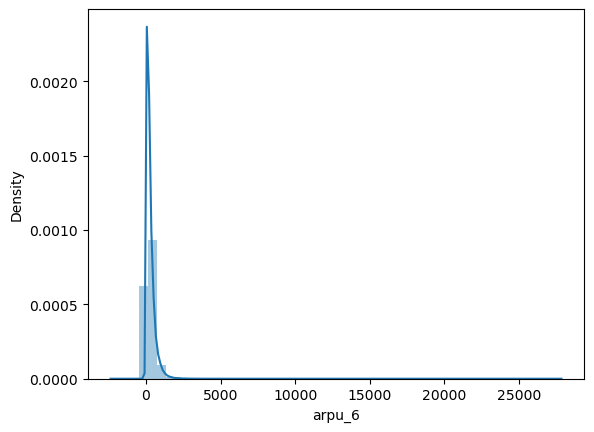

In [229]:
univariate(churn.arpu_6)

count    28000.000000
mean       501.381783
std        428.092941
min      -2258.709000
25%        286.321750
50%        414.039000
75%        617.055500
max      27731.088000
Name: arpu_6, dtype: float64


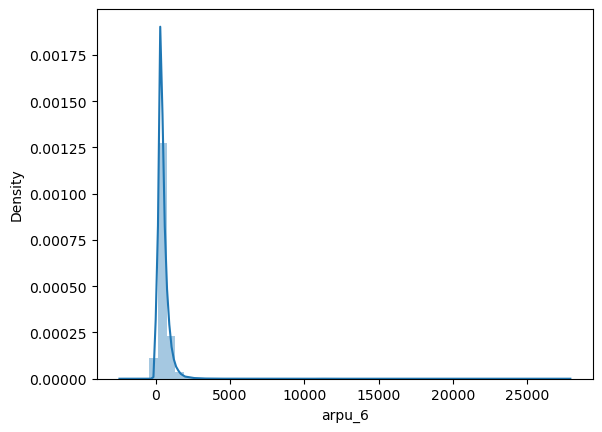

In [230]:
univariate(churn_filtered.arpu_6)

count    69999.000000
mean       125.943607
std        304.990552
min          0.000000
25%          4.110000
50%         27.840000
75%        106.280000
max      10752.560000
Name: onnet_mou_8, dtype: float64


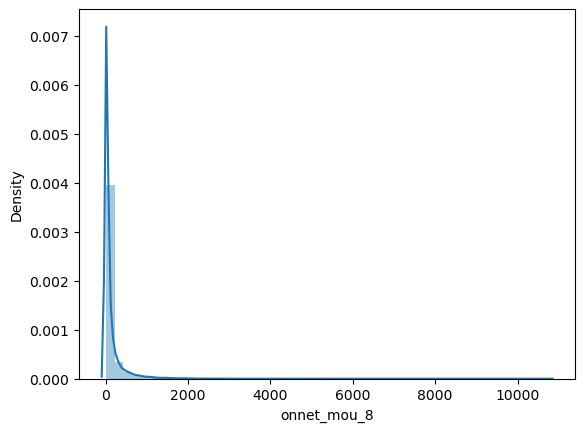

In [231]:
univariate(churn.onnet_mou_8)

count    28000.000000
mean       350.735247
std        437.702334
min          0.000000
25%         97.730000
50%        227.660000
75%        440.115000
max      14007.340000
Name: offnet_mou_8, dtype: float64


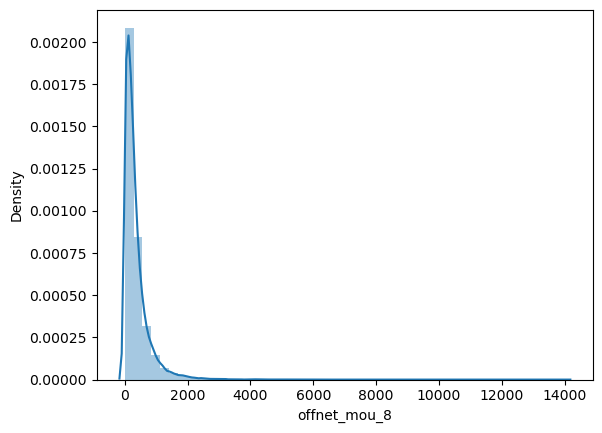

In [232]:
univariate(churn_filtered.offnet_mou_8)

Variables are right skewed

### Bivariate Analysis

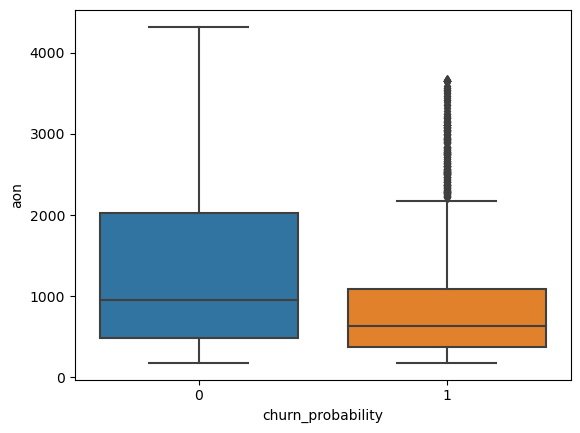

In [233]:
bivariate(churn_filtered.churn_probability, churn_filtered.aon)

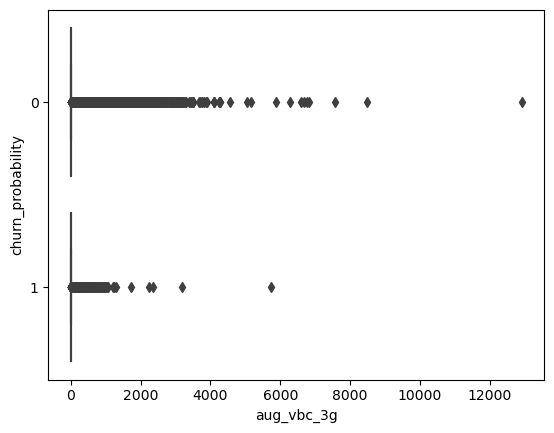

In [234]:
bivariate(churn_filtered.aug_vbc_3g,churn_filtered.churn_probability)

In [235]:
churn_filtered.info(verbose='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28000 entries, 0 to 27999
Data columns (total 155 columns):
 #    Column              Dtype   
---   ------              -----   
 0    loc_og_t2o_mou      float64 
 1    std_og_t2o_mou      float64 
 2    loc_ic_t2o_mou      float64 
 3    arpu_6              float64 
 4    arpu_7              float64 
 5    arpu_8              float64 
 6    onnet_mou_6         float64 
 7    onnet_mou_7         float64 
 8    onnet_mou_8         float64 
 9    offnet_mou_6        float64 
 10   offnet_mou_7        float64 
 11   offnet_mou_8        float64 
 12   roam_ic_mou_6       float64 
 13   roam_ic_mou_7       float64 
 14   roam_ic_mou_8       float64 
 15   roam_og_mou_6       float64 
 16   roam_og_mou_7       float64 
 17   roam_og_mou_8       float64 
 18   loc_og_t2t_mou_6    float64 
 19   loc_og_t2t_mou_7    float64 
 20   loc_og_t2t_mou_8    float64 
 21   loc_og_t2m_mou_6    float64 
 22   loc_og_t2m_mou_7    float64 
 23   loc_og_t2

### Checking for Outliers

<AxesSubplot:>

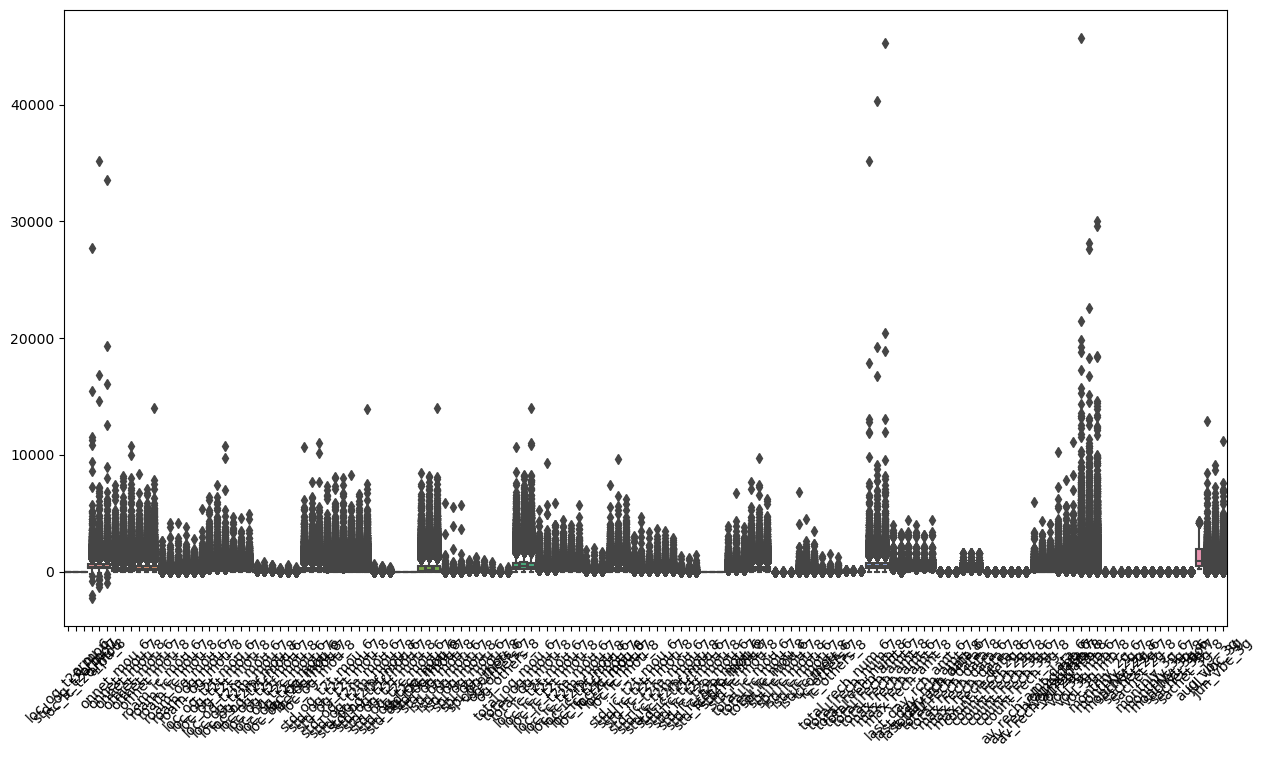

In [236]:
plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
sns.boxplot(data = churn_filtered[num_cols])

In [237]:
def cap_outliers(array,k=3):
    upper_limit = array.mean()+k*array.std()
    lower_limit = array.mean() - k*array.std()
    array[array < lower_limit ] = lower_limit
    array[array > upper_limit ] = upper_limit
    return array

In [238]:
#cap outliers for all numeric values
churn_filtered[num_cols] = churn_filtered[num_cols].apply(cap_outliers,axis=0)

<AxesSubplot:>

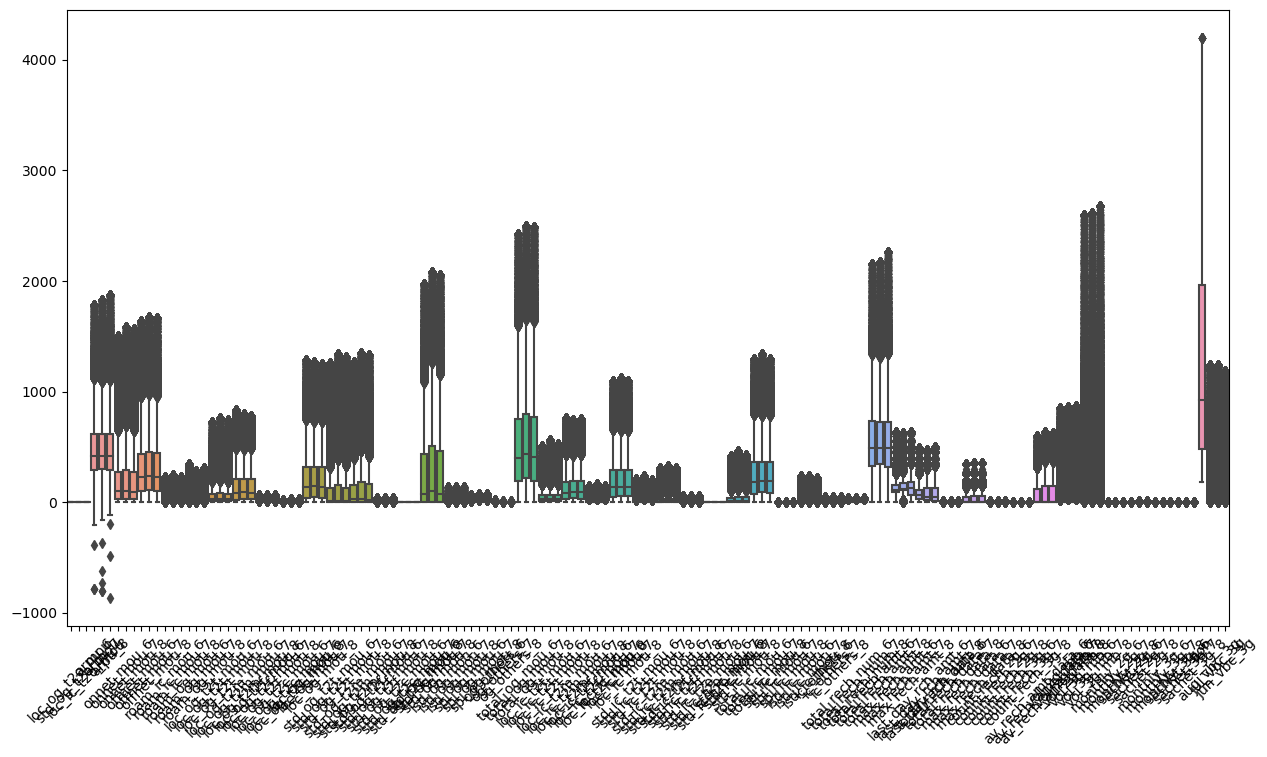

In [239]:
#Re-evaluating outliers
plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
sns.boxplot(data = churn_filtered[num_cols])

# Modelling

### i) Making Predictions

In [240]:
churn_filtered.churn_probability.info()

<class 'pandas.core.series.Series'>
RangeIndex: 28000 entries, 0 to 27999
Series name: churn_probability
Non-Null Count  Dtype   
--------------  -----   
28000 non-null  category
dtypes: category(1)
memory usage: 27.6 KB


In [241]:
#Converting target variable to numeric
churn_filtered['churn_probability'] = pd.to_numeric(churn_filtered['churn_probability'])

### Test Train Split

In [242]:
X = churn_filtered.drop("churn_probability",axis=1)
y = churn_filtered['churn_probability']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=42)

In [243]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(19600, 154)
(19600,)
(8400, 154)
(8400,)


In [244]:
train = pd.concat([X_train, y_train],axis=1)

#aggregate the categorial variables
print("Night_pack_user_6 \n", train.groupby('night_pck_user_6').churn_probability.mean())
print("Night_pack_user_7 \n", train.groupby('night_pck_user_7').churn_probability.mean())
print("Night_pack_user_8 \n", train.groupby('night_pck_user_8').churn_probability.mean())
print("Fb_user_6 \n", train.groupby('fb_user_6').churn_probability.mean())
print("Fb_user_7 \n", train.groupby('fb_user_7').churn_probability.mean())
print("Fb_user_8 \n", train.groupby('fb_user_8').churn_probability.mean())

Night_pack_user_6 
 night_pck_user_6
-1.0    0.076514
0.0     0.055782
1.0     0.075581
Name: churn_probability, dtype: float64
Night_pack_user_7 
 night_pck_user_7
-1.0    0.080772
0.0     0.049588
1.0     0.052356
Name: churn_probability, dtype: float64
Night_pack_user_8 
 night_pck_user_8
-1.0    0.093429
0.0     0.031207
1.0     0.022472
Name: churn_probability, dtype: float64
Fb_user_6 
 fb_user_6
-1.0    0.076514
0.0     0.073025
1.0     0.054451
Name: churn_probability, dtype: float64
Fb_user_7 
 fb_user_7
-1.0    0.080772
0.0     0.062087
1.0     0.048181
Name: churn_probability, dtype: float64
Fb_user_8 
 fb_user_8
-1.0    0.093429
0.0     0.069154
1.0     0.024466
Name: churn_probability, dtype: float64


In [245]:
#replacing categories with aggregated values in each categorial columns
mapping = {'night_pck_user_6'  : { -1: 0.076514, 0: 0.055782, 1: 0.075581},
           'night_pck_user_7'  : { -1: 0.080772, 0: 0.049588, 1: 0.052356},
           'night_pck_user_8'  : { -1: 0.093429, 0: 0.031207, 1: 0.022472},
           'fb_user_6'         : { -1: 0.076514, 0: 0.073025, 1: 0.054451},
           'fb_user_7'         : { -1: 0.080772, 0: 0.062087, 1: 0.048181},
           'fb_user_8'         : { -1: 0.093429, 0: 0.069154, 1: 0.024466}
          }
           
X_train.replace(mapping,inplace = True)
X_test.replace(mapping, inplace = True)

In [246]:
# check data type of categorial columns - make sure they are numeric
X_train[[col for col in cat_cols if col not in['churn_probability']]].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19600 entries, 1208 to 23654
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   night_pck_user_6  19600 non-null  category
 1   night_pck_user_7  19600 non-null  category
 2   night_pck_user_8  19600 non-null  category
 3   fb_user_6         19600 non-null  category
 4   fb_user_7         19600 non-null  category
 5   fb_user_8         19600 non-null  category
dtypes: category(6)
memory usage: 268.7 KB


## PCA

In [247]:
# apply pca to train data
pca = Pipeline([('scalar', StandardScaler()), ('pca',PCA())])

In [248]:
pca.fit(X_train)
churn_pca = pca.fit_transform(X_train)
churn_pca

array([[-4.24966268e+00, -3.12430382e+00, -1.85558595e+00, ...,
        -0.00000000e+00,  4.14062239e-14, -0.00000000e+00],
       [ 4.97504909e+00, -4.65628225e+00,  7.53409238e+00, ...,
         3.21374293e-14,  1.38476484e-17,  1.14918305e-14],
       [-2.48494221e+00, -9.42339622e-01, -3.67484426e+00, ...,
         6.74870363e-16,  1.35339684e-16,  7.95074649e-15],
       ...,
       [-1.61715319e+00,  1.72617968e+00, -3.27634300e+00, ...,
         1.85755392e-17, -1.24353813e-17, -8.04953251e-18],
       [ 2.03869098e+00,  1.41497174e+01, -2.01396882e-01, ...,
         1.05003860e-17,  8.65458012e-18,  9.02774870e-18],
       [ 5.86133921e+00, -5.71423991e+00,  6.29610149e-01, ...,
         1.48685203e-17, -1.34864252e-17,  1.51436414e-18]])

In [249]:
#extracting pca model from pipeline
pca = pca.named_steps['pca']
print(pd.Series(np.round(pca.explained_variance_ratio_.cumsum(),4)*100))

0       12.81
1       22.78
2       30.16
3       35.31
4       39.54
5       42.71
6       45.47
7       48.20
8       50.66
9       53.04
10      55.24
11      57.19
12      59.05
13      60.69
14      62.25
15      63.76
16      65.23
17      66.61
18      67.93
19      69.21
20      70.27
21      71.29
22      72.29
23      73.25
24      74.19
25      75.12
26      76.02
27      76.82
28      77.59
29      78.34
30      79.07
31      79.75
32      80.43
33      81.08
34      81.69
35      82.29
36      82.88
37      83.45
38      84.01
39      84.55
40      85.08
41      85.60
42      86.11
43      86.62
44      87.07
45      87.52
46      87.97
47      88.41
48      88.82
49      89.22
50      89.61
51      90.00
52      90.37
53      90.73
54      91.09
55      91.42
56      91.74
57      92.04
58      92.34
59      92.62
60      92.90
61      93.16
62      93.42
63      93.67
64      93.90
65      94.13
66      94.35
67      94.57
68      94.78
69      94.98
70      95.19
71    

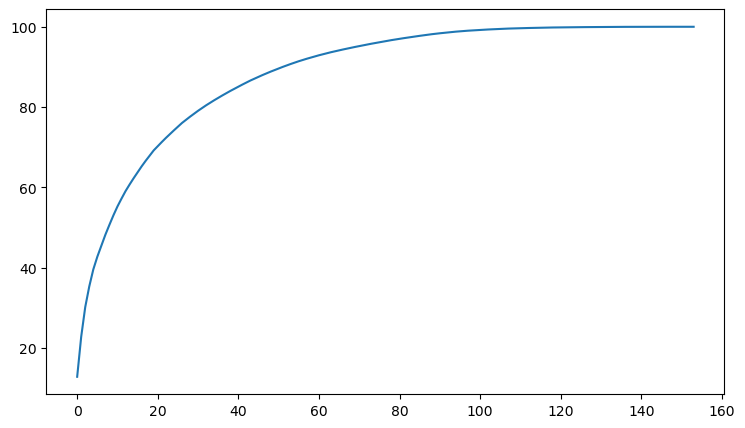

In [250]:
#plot feature variance
features = range(pca.n_components_)
cumulative_variance = np.round(np.cumsum(pca.explained_variance_ratio_)*100,decimals=4)
plt.figure(figsize=(175/20,100/20))
plt.plot(cumulative_variance)

  - ~70 components explain there is about 85-90% of variance
  - ~80 components explain there is about 90-95% of variance

### PCA and Logistic Regression

In [251]:
pca_vars = 80
steps = [('scalar', StandardScaler()), ('pca', PCA(n_components=pca_vars)),
         ('logistic',LogisticRegression(class_weight='balanced'))]
pipeline = Pipeline(steps)

In [252]:
#fit model
pipeline.fit(X_train,y_train)

#check score on train data
pipeline.score(X_train,y_train)

0.8114795918367347

### Hyper Tuning - PCA and Logistic Regression

In [253]:
#class Imbalance
y_train.value_counts()/y_train.shape

0    0.93051
1    0.06949
Name: churn_probability, dtype: float64

In [254]:
#PCA
pca = PCA()
#logistic Regression using class weight
logistic = LogisticRegression(class_weight={0:0.1, 1:0.9})

In [255]:
steps = [('scalar', StandardScaler()), 
         ('pca', PCA(n_components=pca_vars)),
         ('logistic',logistic)]
pca_logistic = Pipeline(steps)

params = {'pca__n_components':[80,100], 'logistic__C':[0.1,0.5,1,2,3,4,5,10],'logistic__penalty':['l1','l2']}
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

model = GridSearchCV(estimator=pca_logistic, cv = folds, param_grid = params, scoring = 'roc_auc', n_jobs = 1, verbose=1)

In [256]:
#fit model
model.fit(X_train,y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scalar', StandardScaler()),
                                       ('pca', PCA(n_components=80)),
                                       ('logistic',
                                        LogisticRegression(class_weight={0: 0.1,
                                                                         1: 0.9}))]),
             n_jobs=1,
             param_grid={'logistic__C': [0.1, 0.5, 1, 2, 3, 4, 5, 10],
                         'logistic__penalty': ['l1', 'l2'],
                         'pca__n_components': [80, 100]},
             scoring='roc_auc', verbose=1)

In [257]:
#cross validation results
pd.DataFrame(model.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logistic__C,param_logistic__penalty,param_pca__n_components,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.339347,0.034231,0.000000,0.000000e+00,0.1,l1,80,"{'logistic__C': 0.1, 'logistic__penalty': 'l1'...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,32
1,0.356166,0.018217,0.000000,0.000000e+00,0.1,l1,100,"{'logistic__C': 0.1, 'logistic__penalty': 'l1'...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,20
2,0.440604,0.026914,0.021869,7.652845e-03,0.1,l2,80,"{'logistic__C': 0.1, 'logistic__penalty': 'l2'...",0.872451,0.853449,0.885528,0.867330,0.902696,0.876291,0.016730,2
3,0.596562,0.066999,0.018722,6.259998e-03,0.1,l2,100,"{'logistic__C': 0.1, 'logistic__penalty': 'l2'...",0.872424,0.854404,0.885402,0.869297,0.902436,0.876792,0.016176,1
4,0.409439,0.030193,0.000000,0.000000e+00,0.5,l1,80,"{'logistic__C': 0.5, 'logistic__penalty': 'l1'...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,23
5,0.360979,0.043582,0.000000,0.000000e+00,0.5,l1,100,"{'logistic__C': 0.5, 'logistic__penalty': 'l1'...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,26
6,0.421934,0.017186,0.018746,6.248212e-03,0.5,l2,80,"{'logistic__C': 0.5, 'logistic__penalty': 'l2'...",0.871832,0.853191,0.885526,0.867432,0.902419,0.876080,0.016732,11
7,0.489804,0.010293,0.013599,4.045177e-03,0.5,l2,100,"{'logistic__C': 0.5, 'logistic__penalty': 'l2'...",0.871800,0.853883,0.884819,0.869172,0.901752,0.876285,0.016087,3
8,0.300092,0.006373,0.000000,0.000000e+00,1,l1,80,"{'logistic__C': 1, 'logistic__penalty': 'l1', ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,17
9,0.331330,0.011756,0.000000,0.000000e+00,1,l1,100,"{'logistic__C': 1, 'logistic__penalty': 'l1', ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,25


In [258]:
#best hyperparametes
print("Best AUC: ", model.best_score_)
print("Best hyperparameters: ", model.best_params_)

Best AUC:  0.8767924723369399
Best hyperparameters:  {'logistic__C': 0.1, 'logistic__penalty': 'l2', 'pca__n_components': 100}


## Choosing best features

In [259]:
# run a random forest model on train data
max_features = int(round(np.sqrt(X_train.shape[1])))    # number of variables to consider to split each node
print(max_features)

rf_model = RandomForestClassifier(n_estimators=100, max_features=max_features, class_weight={0:0.1, 1: 0.9}, oob_score=True, random_state=4, verbose=1)

12


In [260]:
# fit model
rf_model.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   10.5s finished


RandomForestClassifier(class_weight={0: 0.1, 1: 0.9}, max_features=12,
                       oob_score=True, random_state=4, verbose=1)

In [261]:
# OOB score
rf_model.oob_score_

0.9490816326530612

## Feature Importance

In [262]:
# predictors
features = churn_filtered.drop('churn_probability', axis=1).columns

# feature_importance
importance = rf_model.feature_importances_

# create dataframe
feature_importance = pd.DataFrame({'variables': features, 'importance_percentage': importance*100})
feature_importance = feature_importance[['variables', 'importance_percentage']]

# sort features
feature_importance = feature_importance.sort_values('importance_percentage', ascending=False).reset_index(drop=True)
print("Sum of importance=", feature_importance.importance_percentage.sum())
feature_importance

Sum of importance= 100.0


,variables,importance_percentage
0,roam_og_mou_8,4.482616
1,loc_ic_t2m_mou_8,4.394944
2,total_ic_mou_8,4.016692
3,loc_ic_mou_8,3.893008
4,roam_ic_mou_8,3.703442
5,total_rech_amt_8,3.577675
6,total_og_mou_8,3.319381
7,loc_og_t2m_mou_8,3.216686
8,arpu_8,3.021327
9,loc_og_mou_8,2.948281


### Extracting top 45 features

In [263]:
# extract top 'n' features
top_n = 45
top_features = feature_importance.variables[0:top_n]

**Selecing only Important Features in X_train and X_test data sets**

In [264]:
X_train = X_train[top_features]
X_test = X_test[top_features]

In [265]:
# logistic regression
steps = [('scaler', StandardScaler()), 
         ("logistic", LogisticRegression(class_weight={0:0.1, 1:0.9}))
        ]

# compile pipeline
logistic = Pipeline(steps)

# hyperparameter space
params = {'logistic__C': [0.1, 0.5, 1, 2, 3, 4, 5, 10], 'logistic__penalty': ['l1', 'l2']}

# create 5 folds
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 4)

# create gridsearch object
model = GridSearchCV(estimator=logistic, cv=folds, param_grid=params, scoring='roc_auc', n_jobs=-1, verbose=1)

In [266]:
# fit model
model.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=4, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('logistic',
                                        LogisticRegression(class_weight={0: 0.1,
                                                                         1: 0.9}))]),
             n_jobs=-1,
             param_grid={'logistic__C': [0.1, 0.5, 1, 2, 3, 4, 5, 10],
                         'logistic__penalty': ['l1', 'l2']},
             scoring='roc_auc', verbose=1)

In [267]:
# print best hyperparameters
print("Best AUC: ", model.best_score_)
print("Best hyperparameters: ", model.best_params_)

Best AUC:  0.8734453878688815
Best hyperparameters:  {'logistic__C': 0.1, 'logistic__penalty': 'l2'}


### Using Random Forest(PCA has been already applied in the X_Train and X_Test datasets)


In [268]:
rf = RandomForestClassifier(n_estimators=10, max_depth=4, max_features=5, random_state=100, oob_score=True)

In [269]:
X_train.columns

Index(['roam_og_mou_8', 'loc_ic_t2m_mou_8', 'total_ic_mou_8', 'loc_ic_mou_8',
       'roam_ic_mou_8', 'total_rech_amt_8', 'total_og_mou_8',
       'loc_og_t2m_mou_8', 'arpu_8', 'loc_og_mou_8', 'last_day_rch_amt_8',
       'loc_ic_t2t_mou_8', 'max_rech_amt_8', 'loc_og_t2t_mou_8',
       'std_ic_mou_8', 'offnet_mou_8', 'onnet_mou_8', 'std_ic_t2m_mou_8',
       'std_og_mou_8', 'loc_ic_t2f_mou_8', 'arpu_7', 'loc_og_mou_7',
       'loc_ic_t2m_mou_7', 'loc_ic_mou_7', 'std_og_t2m_mou_8', 'aon',
       'total_ic_mou_7', 'total_rech_amt_7', 'av_rech_amt_data_8',
       'loc_og_t2m_mou_7', 'total_og_mou_7', 'arpu_6', 'std_og_mou_7',
       'std_og_mou_6', 'loc_ic_t2m_mou_6', 'loc_ic_mou_6', 'loc_og_t2f_mou_8',
       'spl_og_mou_8', 'total_ic_mou_6', 'onnet_mou_7', 'offnet_mou_6',
       'total_rech_amt_6', 'total_og_mou_6', 'offnet_mou_7',
       'total_rech_num_8'],
      dtype='object')

In [270]:
%%time
rf.fit(X_train, y_train)

Wall time: 397 ms


RandomForestClassifier(max_depth=4, max_features=5, n_estimators=10,
                       oob_score=True, random_state=100)

In [271]:
rf.oob_score_

0.9471938775510204

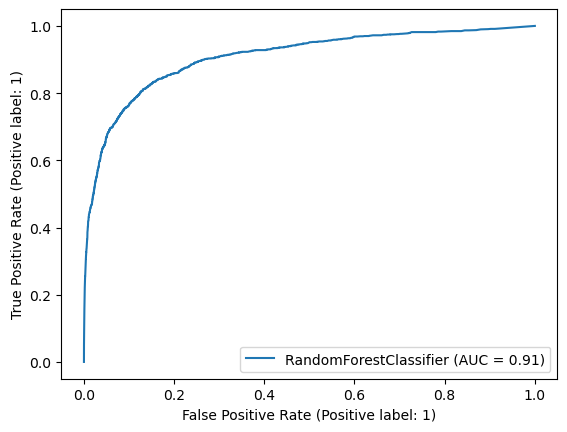

In [272]:
plot_roc_curve(rf, X_train, y_train)
plt.show()

## Sandy - Hyper-parameter tuning for the Random Forest

In [273]:
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

In [274]:
params = {
    'max_depth': [2,3,5,10,20],
    'min_samples_leaf': [5,10,20,50,100,200],
    'n_estimators': [10, 25, 50, 100]
}

In [275]:
grid_search = GridSearchCV(estimator=rf,
                           param_grid=params,
                           cv = 4,
                           n_jobs=-1, verbose=1, scoring="accuracy")

In [276]:
%%time
grid_search.fit(X_train, y_train)

Fitting 4 folds for each of 120 candidates, totalling 480 fits
Wall time: 2min 53s


GridSearchCV(cv=4, estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [2, 3, 5, 10, 20],
                         'min_samples_leaf': [5, 10, 20, 50, 100, 200],
                         'n_estimators': [10, 25, 50, 100]},
             scoring='accuracy', verbose=1)

In [277]:
grid_search.best_score_

0.9494897959183675

In [278]:
rf_best = grid_search.best_estimator_
rf_best

RandomForestClassifier(max_depth=20, min_samples_leaf=5, n_jobs=-1,
                       random_state=42)

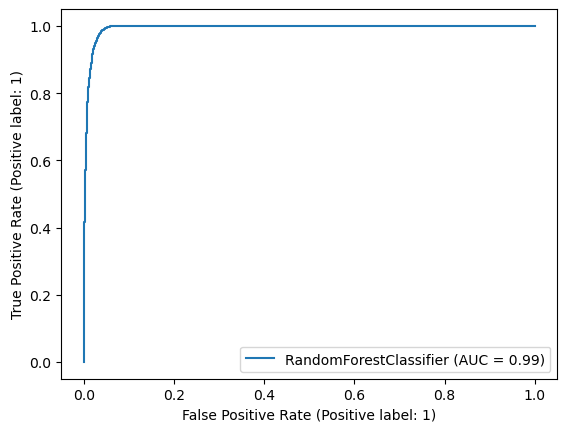

In [279]:
plot_roc_curve(rf_best, X_train, y_train)
plt.show()

From the above Graph, it is clear that the Area Under Curve is 99% and if it performs well on the Test data(unseen data), this model is a well fit model

In [280]:
def evaluate_model(dt_classifier):
    print("Train Accuracy :", accuracy_score(y_train, dt_classifier.predict(X_train)))
    print("Train Confusion Matrix:")
    print(confusion_matrix(y_train,dt_classifier.predict(X_train)))
    print("-"*50)
    print("Test Accuracy :",accuracy_score(y_test,dt_classifier.predict(X_test)))
    print("Test Confusion Matrix:")
    print(confusion_matrix(y_test,dt_classifier.predict(X_test)))

In [281]:
## Appling on Test Data:
evaluate_model(grid_search)

Train Accuracy : 0.967295918367347
Train Confusion Matrix:
[[18173    65]
 [  576   786]]
--------------------------------------------------
Test Accuracy : 0.9472619047619047
Test Confusion Matrix:
[[7751   87]
 [ 356  206]]


In [282]:
rf_best.feature_importances_

array([0.03030314, 0.06591062, 0.06987734, 0.0947673 , 0.02662902,
       0.03290355, 0.04534621, 0.02063811, 0.05602955, 0.06160666,
       0.0217414 , 0.03264024, 0.03992416, 0.0141737 , 0.01180497,
       0.01939942, 0.01959996, 0.00828015, 0.0108805 , 0.00838314,
       0.01617915, 0.01127453, 0.0127037 , 0.01361141, 0.00758619,
       0.01705719, 0.0134159 , 0.01405813, 0.01569299, 0.01086525,
       0.01334424, 0.01365233, 0.01377485, 0.01227309, 0.01186187,
       0.01238852, 0.00475417, 0.00644648, 0.01283142, 0.01337898,
       0.012999  , 0.01305077, 0.01205639, 0.012621  , 0.01128329])

In [283]:
imp_df = pd.DataFrame({
    "Varname": X_train.columns,
    "Imp": rf_best.feature_importances_
})


In [284]:
imp_df.sort_values(by="Imp", ascending=False)

,Varname,Imp
3,loc_ic_mou_8,0.094767
2,total_ic_mou_8,0.069877
1,loc_ic_t2m_mou_8,0.065911
9,loc_og_mou_8,0.061607
8,arpu_8,0.056030
6,total_og_mou_8,0.045346
12,max_rech_amt_8,0.039924
5,total_rech_amt_8,0.032904
11,loc_ic_t2t_mou_8,0.032640
0,roam_og_mou_8,0.030303


In [285]:
X_train.shape

(19600, 45)

In [286]:
len(imp_df)

45

## Business Insights
 - Telecom company needs to pay attention to the outgoing call rates. Provide them with some kind of outgoing call packages - would help customers
 - Recharge amount also need to be focused
 - And also an eye on STD and ISD rates. Perhaps, the rates are too high, some STD and ISD packages would help
 - To look into these issues stated above, it is advised that the telecom company collects customer query and complaint data and work on their services according to the needs of customers.
 
### Top 5 features that would help for prediction are: 
 - loc_ic_mou_8     : Total local incoming calls during the lastest month(Aug)
 - total_ic_mou_8   : Total incoing call and minutes of usage during the lastest month(Aug)
 - loc_ic_t2m_mou_8 : Total local incoming calls from operator T to other mobile along with during the lastest month(Aug)
 - loc_og_mou_8     : Total outgoing during the lastest month(Aug)
 - arpu_8           : Average Revenue per user during the lastest month(Aug)

#                                       Unseen Data

In [287]:
unseen = pd.read_csv("test.csv")

In [288]:
unseen.head()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g
0,69999,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,91.882,65.330,64.445,31.78,20.23,23.11,60.16,32.16,34.83,0.00,0.00,0.00,0.00,0.00,0.00,24.88,20.23,21.06,18.13,10.89,8.36,0.00,13.58,0.00,0.0,0.00,0.03,43.01,44.71,29.43,6.90,0.00,2.05,42.03,7.68,26.43,0.0,0.0,0.0,0.0,0.0,0.0,48.93,7.68,28.48,0.0,0.0,0.0,0.00,0.00,0.03,0.0,0.0,0.0,91.94,52.39,57.94,30.33,37.56,21.98,10.21,4.59,9.53,0.26,0.00,0.00,40.81,42.16,31.51,0.00,0.00,0.00,0.36,1.04,4.34,0.0,0.0,0.00,0.0,0.0,0.0,0.36,1.04,4.34,41.73,43.56,36.26,0.54,0.34,0.39,0.00,0.00,0.00,0.0,0.0,0.00,5,5,4,103,90,60,50,30,30,6/21/2014,7/26/2014,8/24/2014,30,30,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,1692,0.00,0.00,0.00
1,70000,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,414.168,515.568,360.868,75.51,41.21,19.84,474.34,621.84,394.94,0.00,0.00,0.00,0.00,0.00,0.00,75.51,41.21,19.84,473.61,598.08,377.26,0.73,0.00,0.00,0.0,0.00,0.00,549.86,639.29,397.11,0.00,0.00,0.00,0.00,23.76,17.68,0.0,0.0,0.0,0.0,0.0,0.0,0.00,23.76,17.68,0.0,0.0,0.8,0.00,0.00,0.00,0.0,0.0,0.0,549.86,663.06,415.59,19.99,26.95,2.61,160.19,122.29,184.81,1.49,0.00,0.00,181.69,149.24,187.43,0.00,0.00,0.00,0.00,12.51,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.00,12.51,0.00,296.33,339.64,281.66,0.00,0.00,0.00,114.63,177.88,94.23,0.0,0.0,0.00,5,4,5,500,500,500,250,250,250,6/19/2014,7/16/2014,8/24/2014,250,0,0,NaN,NaN,Na

In [289]:
unseen.shape

(30000, 171)

In [290]:
X_train.columns

Index(['roam_og_mou_8', 'loc_ic_t2m_mou_8', 'total_ic_mou_8', 'loc_ic_mou_8',
       'roam_ic_mou_8', 'total_rech_amt_8', 'total_og_mou_8',
       'loc_og_t2m_mou_8', 'arpu_8', 'loc_og_mou_8', 'last_day_rch_amt_8',
       'loc_ic_t2t_mou_8', 'max_rech_amt_8', 'loc_og_t2t_mou_8',
       'std_ic_mou_8', 'offnet_mou_8', 'onnet_mou_8', 'std_ic_t2m_mou_8',
       'std_og_mou_8', 'loc_ic_t2f_mou_8', 'arpu_7', 'loc_og_mou_7',
       'loc_ic_t2m_mou_7', 'loc_ic_mou_7', 'std_og_t2m_mou_8', 'aon',
       'total_ic_mou_7', 'total_rech_amt_7', 'av_rech_amt_data_8',
       'loc_og_t2m_mou_7', 'total_og_mou_7', 'arpu_6', 'std_og_mou_7',
       'std_og_mou_6', 'loc_ic_t2m_mou_6', 'loc_ic_mou_6', 'loc_og_t2f_mou_8',
       'spl_og_mou_8', 'total_ic_mou_6', 'onnet_mou_7', 'offnet_mou_6',
       'total_rech_amt_6', 'total_og_mou_6', 'offnet_mou_7',
       'total_rech_num_8'],
      dtype='object')

In [291]:
imp_features_list = X_train.columns

In [292]:
imp_features_list

Index(['roam_og_mou_8', 'loc_ic_t2m_mou_8', 'total_ic_mou_8', 'loc_ic_mou_8',
       'roam_ic_mou_8', 'total_rech_amt_8', 'total_og_mou_8',
       'loc_og_t2m_mou_8', 'arpu_8', 'loc_og_mou_8', 'last_day_rch_amt_8',
       'loc_ic_t2t_mou_8', 'max_rech_amt_8', 'loc_og_t2t_mou_8',
       'std_ic_mou_8', 'offnet_mou_8', 'onnet_mou_8', 'std_ic_t2m_mou_8',
       'std_og_mou_8', 'loc_ic_t2f_mou_8', 'arpu_7', 'loc_og_mou_7',
       'loc_ic_t2m_mou_7', 'loc_ic_mou_7', 'std_og_t2m_mou_8', 'aon',
       'total_ic_mou_7', 'total_rech_amt_7', 'av_rech_amt_data_8',
       'loc_og_t2m_mou_7', 'total_og_mou_7', 'arpu_6', 'std_og_mou_7',
       'std_og_mou_6', 'loc_ic_t2m_mou_6', 'loc_ic_mou_6', 'loc_og_t2f_mou_8',
       'spl_og_mou_8', 'total_ic_mou_6', 'onnet_mou_7', 'offnet_mou_6',
       'total_rech_amt_6', 'total_og_mou_6', 'offnet_mou_7',
       'total_rech_num_8'],
      dtype='object')

In [293]:
submission_data = unseen.set_index('id')[imp_features_list]
submission_data.shape

(30000, 45)

In [294]:
#missing value ratio for categoriabl Values
print("Missing value ratio")
checkMissingValues(submission_data)

Missing value ratio


roam_og_mou_8          5.583333
loc_ic_t2m_mou_8       5.583333
loc_ic_mou_8           5.583333
roam_ic_mou_8          5.583333
loc_og_t2m_mou_8       5.583333
loc_og_mou_8           5.583333
loc_ic_t2t_mou_8       5.583333
loc_og_t2t_mou_8       5.583333
std_ic_mou_8           5.583333
offnet_mou_8           5.583333
onnet_mou_8            5.583333
std_ic_t2m_mou_8       5.583333
std_og_mou_8           5.583333
loc_ic_t2f_mou_8       5.583333
loc_og_mou_7           3.906667
loc_ic_t2m_mou_7       3.906667
loc_ic_mou_7           3.906667
std_og_t2m_mou_8       5.583333
av_rech_amt_data_8    73.593333
loc_og_t2m_mou_7       3.906667
std_og_mou_7           3.906667
std_og_mou_6           3.896667
loc_ic_t2m_mou_6       3.896667
loc_ic_mou_6           3.896667
loc_og_t2f_mou_8       5.583333
spl_og_mou_8           5.583333
onnet_mou_7            3.906667
offnet_mou_6           3.896667
offnet_mou_7           3.906667
dtype: float64

In [295]:
unseen_missing_data_percent = submission_data.isnull().any()
unseen_impute_cols = unseen_missing_data_percent[unseen_missing_data_percent.gt(0)].index
unseen_impute_cols

Index(['roam_og_mou_8', 'loc_ic_t2m_mou_8', 'loc_ic_mou_8', 'roam_ic_mou_8',
       'loc_og_t2m_mou_8', 'loc_og_mou_8', 'loc_ic_t2t_mou_8',
       'loc_og_t2t_mou_8', 'std_ic_mou_8', 'offnet_mou_8', 'onnet_mou_8',
       'std_ic_t2m_mou_8', 'std_og_mou_8', 'loc_ic_t2f_mou_8', 'loc_og_mou_7',
       'loc_ic_t2m_mou_7', 'loc_ic_mou_7', 'std_og_t2m_mou_8',
       'av_rech_amt_data_8', 'loc_og_t2m_mou_7', 'std_og_mou_7',
       'std_og_mou_6', 'loc_ic_t2m_mou_6', 'loc_ic_mou_6', 'loc_og_t2f_mou_8',
       'spl_og_mou_8', 'onnet_mou_7', 'offnet_mou_6', 'offnet_mou_7'],
      dtype='object')

In [296]:
#For all other cols,, imputing with constant zero using Simple Imputer
imp = SimpleImputer(strategy = 'constant',fill_value =0)
submission_data[unseen_impute_cols] = imp.fit_transform(submission_data[unseen_impute_cols])

In [297]:
checkMissingValues(submission_data)

Series([], dtype: float64)

In [298]:
#unseen['churn_probability'] = model.predict(submission_data)
#output = unseen[['id','churn_probability']]
#output.head()

In [299]:
unseen['churn_probability'] = grid_search.predict(submission_data)
output = unseen[['id','churn_probability']]
output.head()

,id,churn_probability
0,69999,0
1,70000,0
2,70001,1
3,70002,0
4,70003,0


In [300]:
output.to_csv('SanthoshKumar.csv',index=False)

In [301]:
df = pd.read_csv("SanthoshKumar.csv")

In [302]:
df.churn_probability.value_counts()

0    27531
1     2469
Name: churn_probability, dtype: int64